# Imports

In [1]:
import csv
import os
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import random
import dask.dataframe as dd
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
import spacy
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Load processed tweets with target data
with open('data_processed.pkl', 'rb') as f:
  processed = pickle.load(f)

print('Processed data: {}'.format(processed[0:3]))

X, y = zip(*processed) #X = Commentario preprocessado, y = polaridad del comentario, si es negativo(0) o positivo(1)

Processed data: [(['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'day', ';d'], 0), (['upset', 'updat', 'facebook', 'text', 'cri', 'result', 'school', 'today', 'blah'], 0), (['dive', 'time', 'ball', 'manag', 'save', 'rest', 'bound'], 0)]


In [3]:
print(len(X))#tokenized comment
print(len(y))#polarity

1600000
1600000


# LSTM 

In [4]:
@dataclass
class CONFIG():
  """
  """
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 160000
  training_split = .9

Config = CONFIG()

In [5]:
# Split in training validation and test sets for LSTM
X_trainLSTM, X_testLSTM, y_trainLSTM, y_testLSTM = test = train_test_split(X, y,
                                                           shuffle = True, 
                                                           random_state=5, 
                                                           test_size = 100000,
                                                           stratify = y)

print('Train/val size is {}'.format(len(X_trainLSTM))) 
print('Test size is {}'.format(len(X_testLSTM))) 
print('Example train/val comment: {}'.format(X_trainLSTM[:1]))
print('Example test comment: {}'.format(X_testLSTM[:1]))

Train/val size is 1500000
Test size is 100000
Example train/val comment: [['cranchil', 'go', 'live', 'googl', 'app', 'day']]
Example test comment: [['watch', 'good', 'workout', 'morn', 'soooo', 'feel', 'burn']]


In [6]:
def fit_tokenizer(train_sentences, oov_token, vocab_size):
  tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

In [7]:
tokenizer = fit_tokenizer(X, oov_token = Config.oov_token, vocab_size = Config.vocab_size)

word_index = tokenizer.word_index

print('Vocab contains {} words'.format(Config.vocab_size))
print('<OOV> token successfully placed in vocabulary!' if '<OOV>' in word_index else 'No <OOV> in vocabulary! something went wrong :(')

Vocab contains 200000 words
<OOV> token successfully placed in vocabulary!


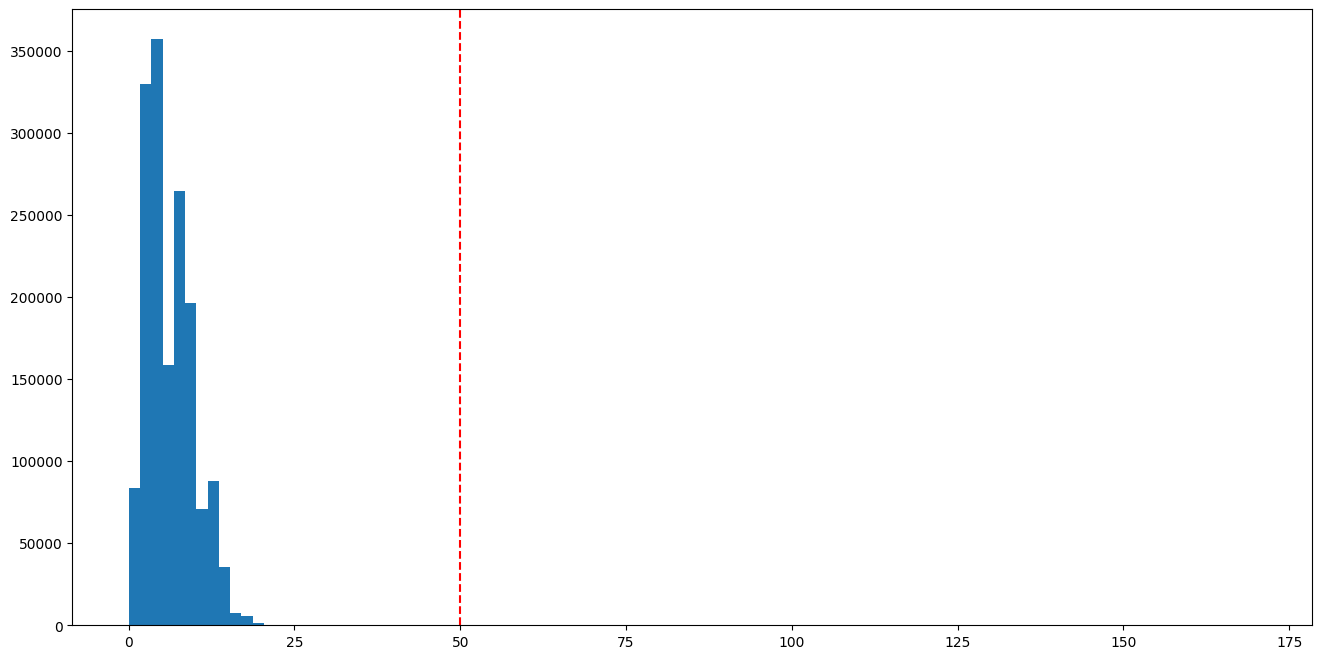

In [8]:
com_lengths = [len(comment) for comment in X]
plt.figure(figsize=(16,8))
plt.hist(com_lengths, 
         bins = 100)
plt.axvline( Config.maxlen, 
            ls = '--',
            c = 'red')
plt.show()

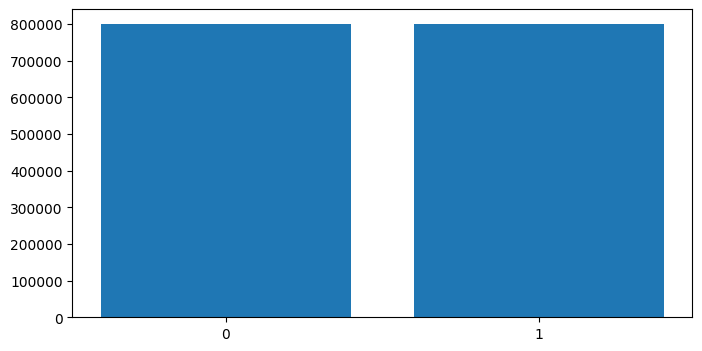

In [9]:
# Convertir la tupla en una serie de pandas
y_series = pd.Series(y)
distribution = y_series.value_counts()
plt.figure(figsize=(8,4))
plt.bar(distribution.index, distribution.values)
plt.xticks([0, 1])

plt.show()

In [10]:
def tokenise_sentences(comments: list,
                       tokenizer: object,
                       padding: str,
                       truncating: str,
                       maxlen: int):
  """
  """

  comments = tokenizer.texts_to_sequences(comments)

  padded_and_trunc_comments = pad_sequences(sequences = comments,
                                          maxlen = maxlen,
                                          truncating = truncating,
                                          padding = padding)
  
  return padded_and_trunc_comments

In [11]:
X_trainLSTM = tokenise_sentences(X_trainLSTM, tokenizer, Config.padding, Config.truncating, Config.maxlen) 
X_testLSTM = tokenise_sentences(X_testLSTM, tokenizer, Config.padding, Config.truncating, Config.maxlen) 

In [12]:
print('Tokenised comments have shape {}'.format(X_trainLSTM.shape))

Tokenised comments have shape (1500000, 50)


In [13]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

In [14]:
sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

In [15]:
# Instantiate model checkpoint callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,verbose=0,mode='auto')

In [16]:
y_trainLSTM = np.array(y_trainLSTM)
y_testLSTM  = np.array(y_testLSTM)

print(y_trainLSTM)

[1 0 0 ... 0 0 0]


In [1]:
'''kf = KFold(n_splits=3, 
           shuffle=True, 
           random_state=1)

fold = 0
epochs = 3

model_eval = defaultdict(list)
# 10 fold cross validation strategy
for train_index, test_index in kf.split(X_trainLSTM):
    cv_X_train, cv_X_val= X_trainLSTM[train_index], X_trainLSTM[test_index]
    cv_y_train, cv_y_val = y_trainLSTM[train_index], y_trainLSTM[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    # reinitialise classifers to reset weights
    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    # train model 
    history_lstm = sentiment_classifier_lstm_model.fit(cv_X_train,
                                               cv_y_train,
                                               validation_data = (cv_X_val, cv_y_val),
                                               callbacks = [early_stopping, reduce_lr],
                                               epochs = epochs,
                                               batch_size = 128)


    # make predictions on hold out validation set for each model

    _ , acc = sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # calculate performance metric

    model_eval['sentiment_classifier_embedding_lstm'].append(acc)

    fold += 1


performance = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])'''

"kf = KFold(n_splits=3, \n           shuffle=True, \n           random_state=1)\n\nfold = 0\nepochs = 3\n\nmodel_eval = defaultdict(list)\n# 10 fold cross validation strategy\nfor train_index, test_index in kf.split(X_trainLSTM):\n    cv_X_train, cv_X_val= X_trainLSTM[train_index], X_trainLSTM[test_index]\n    cv_y_train, cv_y_val = y_trainLSTM[train_index], y_trainLSTM[test_index]\n    print('Fold: {}'.format(fold))\n    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))\n\n    # reinitialise classifers to reset weights\n    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)\n\n    # train model \n    history_lstm = sentiment_classifier_lstm_model.fit(cv_X_train,\n                                               cv_y_train,\n                                               validation_data = (cv_X_val, cv_y_val),\n                                               callbacks = [early_stopping, reduce_lr],\n 

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
epochs = 3
model_eval = defaultdict(list)
X_train_smallLSTM = X_trainLSTM[:80000]
y_train_smallLSTM = y_trainLSTM[:80000]
X_test_smallLSTM = X_testLSTM[:5000]
y_test_smallLSTM = y_testLSTM[:5000]

f1_scores = []  # Lista para almacenar los F1-Score de cada fold

for train_index, test_index in kf.split(X_train_smallLSTM):
    cv_X_train, cv_X_val = X_train_smallLSTM[train_index], X_train_smallLSTM[test_index]
    cv_y_train, cv_y_val = y_train_smallLSTM[train_index], y_train_smallLSTM[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    history_lstm = sentiment_classifier_lstm_model.fit(
        cv_X_train,
        cv_y_train,
        validation_data=(cv_X_val, cv_y_val),
        callbacks=[early_stopping, reduce_lr],
        epochs=epochs,
        batch_size=128
    )

    _, acc, precision, recall, auc= sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # Cálculo manual del F1-Score
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

    model_eval['sentiment_classifier_embedding_lstm'].append(acc)

    # Imprimir métricas del fold actual
    print('Fold: {}'.format(fold))
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(auc))
    print('F1-Score: {:.4f}'.format(f1))

    fold += 1

performance = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])

# Calcular métricas finales del entrenamiento
average_f1_score = np.mean(f1_scores)
final_accuracy = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_precision = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_recall = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_auc = np.mean(model_eval['sentiment_classifier_embedding_lstm'])

print('---------------------------')
print('Métricas finales del entrenamiento')
print('Accuracy: {:.4f}'.format(final_accuracy))
print('Precision: {:.4f}'.format(final_precision))
print('Recall: {:.4f}'.format(final_recall))
print('AUC: {:.4f}'.format(final_auc))
print('F1-Score promedio: {:.4f}'.format(average_f1_score))
print('Performance: {:.4f}'.format(performance))



Fold: 0
# train: 64000
# val: 16000
Epoch 1/3
500/500 [==============================] - 461s 916ms/step - loss: 0.5518 - acc: 0.7153 - precision_2: 0.7122 - recall_2: 0.7222 - auc_2: 0.7928 - val_loss: 0.4920 - val_acc: 0.7627 - val_precision_2: 0.7732 - val_recall_2: 0.7459 - val_auc_2: 0.8432 - lr: 0.0010
Epoch 2/3
500/500 [==============================] - 521s 1s/step - loss: 0.4403 - acc: 0.7986 - precision_2: 0.7994 - recall_2: 0.7971 - auc_2: 0.8780 - val_loss: 0.4984 - val_acc: 0.7551 - val_precision_2: 0.7431 - val_recall_2: 0.7824 - val_auc_2: 0.8370 - lr: 0.0010
Epoch 3/3
500/500 [==============================] - 545s 1s/step - loss: 0.3443 - acc: 0.8499 - precision_2: 0.8485 - recall_2: 0.8517 - auc_2: 0.9277 - val_loss: 0.5235 - val_acc: 0.7554 - val_precision_2: 0.7583 - val_recall_2: 0.7523 - val_auc_2: 0.8355 - lr: 1.0000e-04
Epoch 3: early stopping
500/500 [==============================] - 25s 48ms/step - loss: 0.5235 - acc: 0.7554 - precision_2: 0.7583 - recall_2: 

KeyboardInterrupt: 

### New, with metrics. SMALL

In [17]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
fold = 0
epochs = 3
model_eval = defaultdict(list)
X_train_smallLSTM = X_trainLSTM[:400000] #400.000
y_train_smallLSTM = y_trainLSTM[:400000]
X_test_smallLSTM = X_testLSTM[:25000] #25.000
y_test_smallLSTM = y_testLSTM[:25000]
f1_scores = []  # Lista para almacenar los F1-Score de cada fold

for train_index, test_index in kf.split(X_train_smallLSTM):
    cv_X_train, cv_X_val = X_train_smallLSTM[train_index], X_train_smallLSTM[test_index]
    cv_y_train, cv_y_val = y_train_smallLSTM[train_index], y_train_smallLSTM[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    history_lstm = sentiment_classifier_lstm_model.fit(
        cv_X_train,
        cv_y_train,
        validation_data=(cv_X_val, cv_y_val),
        callbacks=[early_stopping, reduce_lr],
        epochs=epochs,
        batch_size=128
    )

    _, acc, precision, recall, auc= sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # Cálculo manual del F1-Score
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

    model_eval['sentiment_classifier_embedding_lstm'].append(acc)

    # Imprimir métricas del fold actual
    print('Fold: {}'.format(fold))
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(auc))
    print('F1-Score: {:.4f}'.format(f1))

    fold += 1

performance = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])

# Calcular métricas finales del entrenamiento
average_f1_score = np.mean(f1_scores)
final_accuracy = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_precision = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_recall = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_auc = np.mean(model_eval['sentiment_classifier_embedding_lstm'])

print('---------------------------')
print('Métricas finales del entrenamiento')
print('Accuracy: {:.4f}'.format(final_accuracy))
print('Precision: {:.4f}'.format(final_precision))
print('Recall: {:.4f}'.format(final_recall))
print('AUC: {:.4f}'.format(final_auc))
print('F1-Score promedio: {:.4f}'.format(average_f1_score))
print('Performance: {:.4f}'.format(performance))

Fold: 0
# train: 266666
# val: 133334
Epoch 1/3
2084/2084 [==============================] - 1309s 626ms/step - loss: 0.5016 - acc: 0.7555 - precision_1: 0.7570 - recall_1: 0.7529 - auc_1: 0.8356 - val_loss: 0.4789 - val_acc: 0.7698 - val_precision_1: 0.7571 - val_recall_1: 0.7964 - val_auc_1: 0.8550 - lr: 0.0010
Epoch 2/3
2084/2084 [==============================] - 1437s 689ms/step - loss: 0.4253 - acc: 0.8046 - precision_1: 0.8039 - recall_1: 0.8058 - auc_1: 0.8863 - val_loss: 0.4913 - val_acc: 0.7650 - val_precision_1: 0.7783 - val_recall_1: 0.7428 - val_auc_1: 0.8487 - lr: 0.0010
Epoch 3/3
2084/2084 [==============================] - 1449s 695ms/step - loss: 0.3442 - acc: 0.8471 - precision_1: 0.8420 - recall_1: 0.8547 - auc_1: 0.9270 - val_loss: 0.5016 - val_acc: 0.7636 - val_precision_1: 0.7564 - val_recall_1: 0.7795 - val_auc_1: 0.8421 - lr: 1.0000e-04
Epoch 3: early stopping
4167/4167 [==============================] - 93s 22ms/step - loss: 0.5016 - acc: 0.7636 - precision_1: 

# SVM


In [31]:
print(len(X))#tokenized comment
print(len(y))#polarity

1600000
1600000


In [32]:
# Crear el vectorizador
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

# Convertir los comentarios en texto plano
X_text = [' '.join(comment) for comment in X]

# Convertir los comentarios en vectores numéricos
X_vectors = vectorizer.fit_transform(X_text)

#print(X_vectors[:3])
print(X_vectors[:3])

  (0, 8795)	0.1881957875834248
  (0, 5862)	0.5398787620224399
  (0, 8778)	0.37495511846745117
  (0, 14166)	0.19783307416127374
  (0, 32487)	0.470916662855385
  (0, 5187)	0.3995395892269102
  (0, 2441)	0.33464849475452774
  (1, 3930)	0.4089174758982818
  (1, 36870)	0.21009705832952982
  (1, 31544)	0.2698206592005453
  (1, 30217)	0.3946462967828321
  (1, 8119)	0.3145395584397763
  (1, 36014)	0.3345510735228204
  (1, 11956)	0.34553968021745585
  (1, 38827)	0.3106763569620464
  (1, 38877)	0.3651298567519296
  (2, 4533)	0.5373862923485065
  (2, 30195)	0.31180339506353155
  (2, 31380)	0.33344362089639334
  (2, 22116)	0.35158849227555566
  (2, 2791)	0.3615804330101143
  (2, 36603)	0.19953697772691764
  (2, 9816)	0.4567713699319499


In [38]:
# Reducir los conjuntos de datos de entrenamiento y prueba
import scipy.sparse as sp

# Obtener la cantidad total de filas en X_vectors
total_rows = X_vectors.shape[0]

# Obtener los primeros 200,000 valores
first_values = X_vectors[:200000, :]

# Obtener los últimos 200,000 valores
last_values = X_vectors[total_rows - 200000:, :]

# Concatenar los primeros y últimos valores
X_smallSVM = sp.vstack([first_values, last_values])
y_smallSVM = y[:200000] + y[-200000:]


print(X_smallSVM[:1],"\n")
print(y_smallSVM[:7],"\n\n") 
print(len(y_smallSVM))
print(X_smallSVM.shape)

  (0, 8795)	0.1881957875834248
  (0, 5862)	0.5398787620224399
  (0, 8778)	0.37495511846745117
  (0, 14166)	0.19783307416127374
  (0, 32487)	0.470916662855385
  (0, 5187)	0.3995395892269102
  (0, 2441)	0.33464849475452774 

(0, 0, 0, 0, 0, 0, 0) 


400000
(400000, 42600)


In [39]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_trainSVM, X_testSVM, y_trainSVM, y_testSVM = train_test_split(X_smallSVM, y_smallSVM,
                                                           shuffle = True, 
                                                           random_state=16, 
                                                           test_size = 0.2,
                                                           stratify = y_smallSVM)

### Buscant la millor C

In [99]:
'''
# Reducir los conjuntos de datos de entrenamiento y prueba
X_train_smallSVM = X_trainSVM[:50000]
y_train_smallSVM = y_trainSVM[:50000]
X_test_smallSVM = X_testSVM[:5000]
y_test_smallSVM = y_testSVM[:5000]

# Crear el modelo SVM
svm_model = SVC(kernel='linear')

# Definir los valores de C que se probarán
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Entrenar el modelo con los datos de características numéricas
grid_search.fit(X_train_smallSVM, y_train_smallSVM)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
svm_predictions = best_model.predict(X_test_smallSVM)

# Calcular las métricas de evaluación
svm_report = classification_report(y_test_smallSVM, svm_predictions)

print("Best parameters: ", best_params)
print("SVM Classification Report:")
print(svm_report)
'''

'\n# Reducir los conjuntos de datos de entrenamiento y prueba\nX_train_smallSVM = X_trainSVM[:50000]\ny_train_smallSVM = y_trainSVM[:50000]\nX_test_smallSVM = X_testSVM[:5000]\ny_test_smallSVM = y_testSVM[:5000]\n\n# Crear el modelo SVM\nsvm_model = SVC(kernel=\'linear\')\n\n# Definir los valores de C que se probarán\nparam_grid = {\'C\': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}\n\n# Crear el objeto GridSearchCV\ngrid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring=\'accuracy\', cv=5)\n\n# Entrenar el modelo con los datos de características numéricas\ngrid_search.fit(X_train_smallSVM, y_train_smallSVM)\n\n# Obtener el mejor modelo y los mejores parámetros\nbest_model = grid_search.best_estimator_\nbest_params = grid_search.best_params_\n\n# Realizar predicciones en el conjunto de prueba con el mejor modelo\nsvm_predictions = best_model.predict(X_test_smallSVM)\n\n# Calcular las métricas de evaluación\nsvm_report = classification_report(y_test_smallSVM, sv

## Small


In [40]:
# Reducir los conjuntos de datos de entrenamiento y prueba
X_train_smallSVM = X_trainSVM[:400000]
y_train_smallSVM = y_trainSVM[:400000]
X_test_smallSVM = X_testSVM[:25000]
y_test_smallSVM = y_testSVM[:25000]

print(X_train_smallSVM[:3],"\n")
print(y_train_smallSVM[:7],"\n\n")
print(X_test_smallSVM[:3],"\n")
print(y_test_smallSVM[:45],"\n") 

  (0, 8544)	0.704278372266823
  (0, 32721)	0.7099239215276482
  (1, 25939)	0.6117006361236081
  (1, 12577)	0.49847024089029324
  (1, 5248)	0.47419396919746204
  (1, 17280)	0.39049946259822516
  (2, 23277)	0.42179198663672596
  (2, 40173)	0.350700650327057
  (2, 39756)	0.3172474536403458
  (2, 15896)	0.36065011840771555
  (2, 3263)	0.3421641298888126
  (2, 14490)	0.23745379916599846
  (2, 40167)	0.32775846818917226
  (2, 21478)	0.25936956894634394
  (2, 31544)	0.346738134381526 

[1, 0, 1, 1, 1, 0, 0] 


  (0, 6426)	0.5318810621513306
  (0, 13530)	0.3693543958508132
  (0, 11716)	0.6225276805525817
  (0, 41577)	0.3608379399963901
  (0, 36870)	0.2508687585081839
  (1, 23228)	0.5050769549068636
  (1, 3516)	0.3591507128176753
  (1, 29975)	0.2661923349827938
  (1, 32751)	0.30871147851087605
  (1, 6896)	0.3192284379235022
  (1, 14980)	0.1829394267105829
  (1, 40080)	0.2271798728546617
  (1, 29280)	0.30537918207830433
  (1, 2838)	0.2709215918195497
  (1, 31793)	0.20097732966632256
  (1, 37044)

In [41]:
c = 0
for u in y_train_smallSVM:
    if u != 0:
        c +=1
print (c)

160000


In [42]:
# Crear y entrenar el modelo SVM
svm_model = SVC(C=0.1, kernel='linear')

# Entrenar el modelo con los datos de características numéricas
print("Entrenando el modelo SVM...")
svm_model.fit(X_train_smallSVM, y_train_smallSVM)
print("¡Entrenamiento completado!")
# Realizar predicciones en el conjunto de prueba
svm_predictions = svm_model.predict(X_test_smallSVM)

# Calcular las métricas de evaluación
svm_report = classification_report(y_test_smallSVM, svm_predictions)

print("SVM Classification Report:")
print(svm_report)

Entrenando el modelo SVM...
¡Entrenamiento completado!
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74     12382
           1       0.74      0.81      0.77     12618

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



# Tree


In [43]:
X_smallDT = sp.vstack([first_values, last_values])
y_smallDT = y[:200000] + y[-200000:]


print(X_smallDT[:1],"\n")
print(y_smallDT[:7],"\n\n") 
print(len(y_smallDT))
print(X_smallDT.shape)

  (0, 8795)	0.1881957875834248
  (0, 5862)	0.5398787620224399
  (0, 8778)	0.37495511846745117
  (0, 14166)	0.19783307416127374
  (0, 32487)	0.470916662855385
  (0, 5187)	0.3995395892269102
  (0, 2441)	0.33464849475452774 

(0, 0, 0, 0, 0, 0, 0) 


400000
(400000, 42600)


In [45]:
#podemos reciclar el vectorizado del svm
# Dividir los datos en conjuntos de entrenamiento y prueba
X_trainDT, X_testDT, y_trainDT, y_testDT = train_test_split(X_smallDT , y_smallDT,
                                                           shuffle = True, 
                                                           random_state=16, 
                                                           test_size = 0.2,
                                                           stratify = y_smallDT)

In [46]:
# Reducir los conjuntos de datos de entrenamiento y prueba
'''
X_train_smallDT = X_trainDT[:30000]
y_train_smallDT = y_trainDT[:30000]
X_test_smallDT = X_testDT[:500]
y_test_smallDT = y_testDT[:500]
'''
X_train_smallDT = X_trainDT[:400000]
y_train_smallDT = y_trainDT[:400000]
X_test_smallDT = X_testDT[:25000]
y_test_smallDT = y_testDT[:25000]

print(X_train_smallDT[:3],"\n")
print(y_train_smallDT[:3],"\n\n")
print(X_test_smallDT[:3],"\n")
print(y_test_smallDT[:3],"\n") 

  (0, 8544)	0.704278372266823
  (0, 32721)	0.7099239215276482
  (1, 25939)	0.6117006361236081
  (1, 12577)	0.49847024089029324
  (1, 5248)	0.47419396919746204
  (1, 17280)	0.39049946259822516
  (2, 23277)	0.42179198663672596
  (2, 40173)	0.350700650327057
  (2, 39756)	0.3172474536403458
  (2, 15896)	0.36065011840771555
  (2, 3263)	0.3421641298888126
  (2, 14490)	0.23745379916599846
  (2, 40167)	0.32775846818917226
  (2, 21478)	0.25936956894634394
  (2, 31544)	0.346738134381526 

[1, 0, 1] 


  (0, 6426)	0.5318810621513306
  (0, 13530)	0.3693543958508132
  (0, 11716)	0.6225276805525817
  (0, 41577)	0.3608379399963901
  (0, 36870)	0.2508687585081839
  (1, 23228)	0.5050769549068636
  (1, 3516)	0.3591507128176753
  (1, 29975)	0.2661923349827938
  (1, 32751)	0.30871147851087605
  (1, 6896)	0.3192284379235022
  (1, 14980)	0.1829394267105829
  (1, 40080)	0.2271798728546617
  (1, 29280)	0.30537918207830433
  (1, 2838)	0.2709215918195497
  (1, 31793)	0.20097732966632256
  (1, 37044)	0.182564676

In [47]:
# Crear y entrenar el modelo de clasificación Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_smallDT, y_train_smallDT)

# Realizar predicciones en el conjunto de prueba
decision_tree_predictions = decision_tree_model.predict(X_test_smallDT)

# Calcular las métricas de evaluación
decision_tree_report = classification_report(y_test_smallDT, decision_tree_predictions)

print("Decision Tree Classification Report:")
print(decision_tree_report)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     12382
           1       0.70      0.71      0.71     12618

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000



# MODEL FINAL

In [17]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
fold = 0
epochs = 5
model_eval = defaultdict(list)

f1_scores = []  # Lista para almacenar los F1-Score de cada fold

for train_index, test_index in kf.split(X_trainLSTM):
    cv_X_train, cv_X_val = X_trainLSTM[train_index], X_trainLSTM[test_index]
    cv_y_train, cv_y_val = y_trainLSTM[train_index], y_trainLSTM[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    history_lstm = sentiment_classifier_lstm_model.fit(
        cv_X_train,
        cv_y_train,
        validation_data=(cv_X_val, cv_y_val),
        callbacks=[early_stopping, reduce_lr],
        epochs=epochs,
        batch_size=128
    )

    _, acc, precision, recall, auc = sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # Cálculo manual del F1-Score
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

    model_eval['sentiment_classifier_embedding_lstm'].append(acc)

    # Imprimir métricas del fold actual
    print('Fold: {}'.format(fold))
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(auc))
    print('F1-Score: {:.4f}'.format(f1))

    fold += 1

# Entrenamiento completo, ahora evaluamos el conjunto de pruebas
_, test_acc, test_precision, test_recall, test_auc = sentiment_classifier_lstm_model.evaluate(X_testLSTM, y_testLSTM)

# Cálculo manual del F1-Score para el conjunto de pruebas
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Almacenar las métricas de prueba
model_eval['sentiment_classifier_embedding_lstm_test'] = [test_acc, test_precision, test_recall, test_auc, test_f1]

performance = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])

# Calcular métricas finales del entrenamiento
average_f1_score = np.mean(f1_scores)
final_accuracy = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_precision = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_recall = np.mean(model_eval['sentiment_classifier_embedding_lstm'])
final_auc = np.mean(model_eval['sentiment_classifier_embedding_lstm'])

print('---------------------------')
print('Métricas finales del entrenamiento')
print('Accuracy: {:.4f}'.format(final_accuracy))
print('Precision: {:.4f}'.format(final_precision))
print('Recall: {:.4f}'.format(final_recall))
print('AUC: {:.4f}'.format(final_auc))
print('F1-Score promedio: {:.4f}'.format(average_f1_score))
print('Performance: {:.4f}'.format(performance))

# Imprimir métricas del conjunto de pruebas
print('---------------------------')
print('Métricas del conjunto de pruebas')
print('Accuracy: {:.4f}'.format(test_acc))
print('Precision: {:.4f}'.format(test_precision))
print('Recall: {:.4f}'.format(test_recall))
print('AUC: {:.4f}'.format(test_auc))
print('F1-Score: {:.4f}'.format(test_f1))

Fold: 0
# train: 1000000
# val: 500000
Epoch 1/5
7813/7813 [==============================] - 5516s 706ms/step - loss: 0.4755 - acc: 0.7724 - precision_1: 0.7715 - recall_1: 0.7736 - auc_1: 0.8542 - val_loss: 0.4695 - val_acc: 0.7840 - val_precision_1: 0.7890 - val_recall_1: 0.7763 - val_auc_1: 0.8678 - lr: 0.0010
Epoch 2/5
7813/7813 [==============================] - 5608s 718ms/step - loss: 0.4221 - acc: 0.8049 - precision_1: 0.8045 - recall_1: 0.8051 - auc_1: 0.8878 - val_loss: 0.4582 - val_acc: 0.7859 - val_precision_1: 0.7771 - val_recall_1: 0.8026 - val_auc_1: 0.8685 - lr: 0.0010
Epoch 3/5
7813/7813 [==============================] - 5551s 711ms/step - loss: 0.3789 - acc: 0.8271 - precision_1: 0.8207 - recall_1: 0.8368 - auc_1: 0.9105 - val_loss: 0.4751 - val_acc: 0.7791 - val_precision_1: 0.7721 - val_recall_1: 0.7929 - val_auc_1: 0.8596 - lr: 0.0010
Epoch 4/5
7813/7813 [==============================] - 5604s 717ms/step - loss: 0.3216 - acc: 0.8539 - precision_1: 0.8462 - recal

In [ ]:
sentiment_classifier_lstm_model.save('sentiment_classifier_lstm_model.h5') # You can also use '.tf' extension for SavedModel format

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('sentiment_classifier_lstm_model.h5')